In [19]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader

sys.path.append("/home/wangbrh/BrainProject/")
sys.path.append("/home/wangbrh/BrainProject/utils")
sys.path.append("/home/wangbrh/BrainProject/utils/models")
sys.path.append("/home/wangbrh/BrainProject/datasets/forrest/movie_snapshots")

from utils import Datasets, plotUtils, loadUtils, featureUtils, models, extractRunFrames, Paths
from plotUtils import peekImageFolderDS, sampleAE, plotCompareFeatures, showAnat
from loadUtils import loadModel, loadFMRI, loadFeatures
from fitUtils import fitAE, fitFeatureModel
from featureUtils import generateAllFeatures, convolveFeatures
from Datasets import SingleDirDataset, FeatureDataset
from models import SimpleConvAE, FeatureNet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
torch.cuda.is_available()

True

# Train Autoencoder

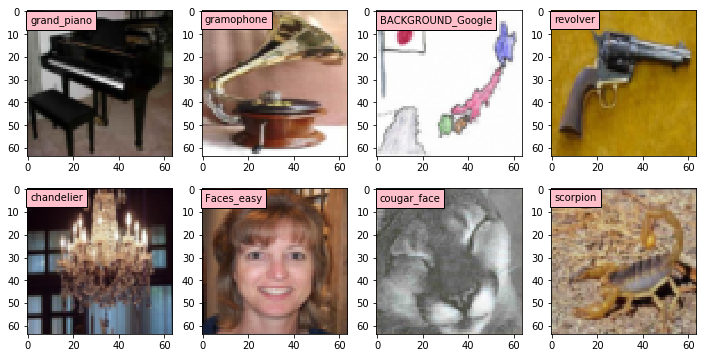

In [5]:
image_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
])
traindataset = torchvision.datasets.ImageFolder(
    root=Paths.objects_dataset_path,
    transform=image_transforms
)
trainloader = DataLoader(traindataset, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)

peekImageFolderDS(traindataset)

In [11]:
import torch.nn as nn


class SimpleConvAESmall(nn.Module):
    def __init__(self):
        super().__init__()

        # in: b, 3, 64, 64
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 4, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(4),

            nn.MaxPool2d(2, stride=2, return_indices=True),
        )

        self.unpool = nn.MaxUnpool2d(2, stride=2, padding=0)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=1, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        encoded, indices = self.encoder(x)
        out = self.unpool(encoded, indices)
        out = self.decoder(out)
        return (out, encoded)


In [28]:
from torchsummary import summary
simpleAE = SimpleConvAE().cuda()
summary(simpleAE, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
       BatchNorm2d-3           [-1, 16, 64, 64]              32
            Conv2d-4            [-1, 4, 64, 64]             580
              ReLU-5            [-1, 4, 64, 64]               0
       BatchNorm2d-6            [-1, 4, 64, 64]               8
         MaxPool2d-7  [[-1, 4, 32, 32], [-1, 4, 32, 32]]               0
       MaxUnpool2d-8            [-1, 4, 64, 64]               0
   ConvTranspose2d-9           [-1, 16, 64, 64]             592
             ReLU-10           [-1, 16, 64, 64]               0
  ConvTranspose2d-11            [-1, 3, 64, 64]             435
             ReLU-12            [-1, 3, 64, 64]               0
Total params: 2,095
Trainable params: 2,095
Non-trainable params: 0
--------------------------

In [29]:
from torch import nn, optim

aeNet = SimpleConvAE().cuda()
criterion = nn.MSELoss()
optimizer = optim.SGD(aeNet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
fitAE(aeNet, criterion, optimizer, trainloader, epochs=50)

In [30]:
aeNet(traindataset.__getitem__(0)[0].unsqueeze(0).cuda())[
            1].view(1, -1).shape[1]

4096

In [31]:
# Save to 'model.pth'
torch.save({
            'model_state_dict': aeNet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, './savedModels/SimpleConvAE3.pth')

In [32]:
import random
import matplotlib.pyplot as plt

def sampleAE(dataset, model, index=None):
    """ Plots the input image and output image of an autoencoder side by side

    Keyword arguments:
    dataset -- torch dataset object to select images from
    model == torch nn model to feed image
    index -- optionally specifies dataset item index to display
    """
    if not index:
        index = random.randint(0, dataset.__len__())

    inputImg = dataset.__getitem__(index)[0]
    outputImg = model.forward(inputImg.cuda().unsqueeze(0))[0].squeeze().cpu()

    fig = plt.figure(figsize=(6, 12), facecolor='white')
    fig.suptitle('Image #%d' % index, y=0.635, fontsize=16)
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_xlabel('Input')
    plt.imshow(inputImg.permute(1, 2, 0).detach().numpy())
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_xlabel('Decoded')
    plt.imshow(outputImg.permute(1, 2, 0).detach().numpy())
    plt.show()

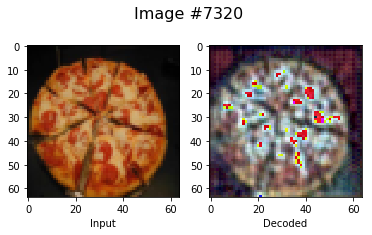

In [41]:
sampleAE(traindataset, aeNet)

# Encode Forrest To Features

In [12]:
# Load from 'model.pth'
from torch import optim

aeNet = SimpleConvAESmall().cuda()
optimizer = optim.SGD(aeNet.parameters(), lr=0.001, momentum=0.9)
loadModel(os.path.join(Paths.models_path, 'SimpleConvAE3.pth'), aeNet, optimizer)
aeNet.eval()

SimpleConvAESmall(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
)

In [37]:
for i in range(8):
    extractRunFrames(Paths.movie_run_path(i), Paths.movie_run_snapshots_path(i), 'run-{}'.format(i))

In [44]:
generateAllFeatures(aeNet, \
                    [Paths.movie_run_snapshots_path(i) for i in range(8)], \
                    Paths.encoded_features('SimpleConvAESmall', 1))

Encoding run 0 frames...
Feature Shape: torch.Size([454, 4096])



Encoding run 1 frames...
Feature Shape: torch.Size([444, 4096])



Encoding run 2 frames...
Feature Shape: torch.Size([441, 4096])



Encoding run 3 frames...
Feature Shape: torch.Size([491, 4096])



Encoding run 4 frames...
Feature Shape: torch.Size([465, 4096])



Encoding run 5 frames...
Feature Shape: torch.Size([442, 4096])



Encoding run 6 frames...
Feature Shape: torch.Size([545, 4096])



Encoding run 7 frames...
Feature Shape: torch.Size([340, 4096])


# Train BOLD Model

In [ ]:
# from torch.utils.data import DataLoader

# [anat_data, mask_data] = loadFMRI(1, 0)
# features = loadFeatures(1, 0, responseLen=anat_data.shape[3])
# features_conv = convolveFeatures(features, 2)
# # plotCompareFeatures(features[:,:10], features_conv[:,:10])
# featureData = FeatureDataset(torch.tensor(features_conv).float(), torch.tensor(anat_data), torch.tensor(mask_data).bool())
# featureLoader = DataLoader(featureData, batch_size=64, shuffle=True, num_workers=1,pin_memory=True)

In [57]:
# Load run features datasets

import random

def loadRunDatasets(sub):
    all_run_datasets = []
    for i in range(8):
        [anat_data, mask_data] = loadFMRI(sub, i)
        features = loadFeatures('SimpleConvAESmall', sub, i, responseLen=anat_data.shape[3])
        features_conv = convolveFeatures(features, 2)
        featureData = FeatureDataset(torch.tensor(features_conv).float(), torch.tensor(anat_data), torch.tensor(mask_data).bool())
        all_run_datasets.append(featureData)
    return all_run_datasets

all_run_datasets = loadRunDatasets(1)

FMRI Frames: 451
Movie Run Frames: 451
FMRI Frames: 441
Movie Run Frames: 441
FMRI Frames: 438
Movie Run Frames: 438
FMRI Frames: 488
Movie Run Frames: 488
FMRI Frames: 462
Movie Run Frames: 462
FMRI Frames: 439
Movie Run Frames: 439
FMRI Frames: 542
Movie Run Frames: 542
FMRI Frames: 338
Movie Run Frames: 338


In [68]:
[anat_data, mask_data] = loadFMRI(1, 0)
features = loadFeatures('SimpleConvAESmall', 1, 0, responseLen=anat_data.shape[3])

FMRI Frames: 451
Movie Run Frames: 451


In [73]:
features_conv = convolveFeatures(features, 2)
features_conv.shape

(451, 4096)

In [75]:
anat_data.shape

(80, 80, 35, 451)

In [76]:
mask_data.shape

(65, 77, 60)

In [74]:
torch.masked_select(anat_data[:, :, :, 1], mask_data[:,:,:,1], out=None)

IndexError: too many indices for array

In [65]:
all_run_datasets[0].__getitem__(0)

RuntimeError: The size of tensor a (35) must match the size of tensor b (60) at non-singleton dimension 2

In [60]:
import numpy as np

def correlateFeature(dataset, model,  idx):
    feature = dataset.__getitem__(idx)[0]
    label = dataset.__getitem__(idx)[1]
    pred = model.forward(torch.tensor(feature).float().cuda()).cpu()

    pearsonCorr = torch.tensor(np.corrcoef(pred.clone().detach().numpy(), label.numpy())).float()
    return pearsonCorr[0, 1].item()

def evaluateFeatureDataset(dataset, model):
    scores = []
    for i in range(len(dataset)):
        score = correlateFeature(dataset, model, i)
        scores.append(score)
    return sum(scores)/len(scores)

In [62]:
# cross validation train

# num_ffa_voxels = np.sum(np.array(mask_data, dtype=bool))
from torch.utils.data import BatchSampler, RandomSampler, ConcatDataset

def crossValidationFit(model, datasets):
    eval_scores = np.empty((8, 2))
    for i in range(8):
        # create indices for train and test split
        train_runs_indices = [j for j in range(8)]
        test_run = train_runs_indices.pop(i)
        train_dataset_list = [all_run_datasets[i] for i in train_runs_indices]

        # create combined training set
        combined_train_dataset = ConcatDataset(train_dataset_list)
        train_sampler = RandomSampler(combined_train_dataset)
        train_loader = DataLoader(combined_train_dataset, sampler=train_sampler, batch_size=64, num_workers=0, pin_memory=True)

        # create model, optimizer, error function
        num_features = 4096
        num_ffa_voxels = 80
        model = FeatureNet(num_features, num_ffa_voxels).cuda()
        model.train()
        criterion = torch.nn.MSELoss() 
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)


        # fit and save model
        fitFeatureModel(model, criterion, optimizer, train_loader, epochs=100)
        torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, './savedModels/featureNet_test-{}.pth'.format(test_run))
        
        # Evaluate model
        model.eval()
        # in sample error
        eval_scores[i, 0] = evaluateFeatureDataset(combined_train_dataset, model)
        # out of sample error
        test_dataset = all_run_datasets[i]
        eval_scores[i, 1] = evaluateFeatureDataset(test_dataset, model)
    return eval_scores


crossValidationFit(None, None)

RuntimeError: The size of tensor a (35) must match the size of tensor b (60) at non-singleton dimension 2

In [ ]:
for i in range(8):
  train_runs_indices = [j for j in range(8)]
  test_run = train_runs_indices.pop(i)
  print(test_run)
  print(train_runs_indices)